# Prologue

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import pandasql as pdsql

In [3]:
pdsqleval = lambda q: pdsql.sqldf(q, globals())

In [4]:
# this code was written by chatgpt lol
def format_size(size):
    suffixes = ['B', 'kB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB']
    i = 0
    while size >= 1024 and i < len(suffixes) - 1:
        size /= 1024.0
        i += 1
    return f"{size:.1f} {suffixes[i]}"

In [5]:
# this code was written by chatgpt lol (though it made a mistake originally)
def format_time(time_in_ns):
    # Time units
    units = ['ns', 'µs', 'ms', 's']
    
    # Start with nanoseconds
    i = 0
    
    # Convert time to the appropriate unit
    while time_in_ns >= 1000 and i < len(units) - 1:
        time_in_ns /= 1000.0
        i += 1
    
    # Format the result
    return f"{time_in_ns:.1f} {units[i]}"

# Data 04/03/2025

In [8]:
master2 = pd.read_csv("../../data/2025-03-04-time-18-40-26-second-run-finch2/master.csv")

# applies units and formats strings
formatfuncs = {
    "readBW_bytes": format_size,
    "writeBW_bytes": format_size,
    "avgreadlat_ns": format_time,
    "avgwritelat_ns": format_time
}
for cname, cfunc in formatfuncs.items():
    master2[cname.split('_')[0]] = master2[cname].apply(cfunc)

cols = [col for col in list(master2)[1:] if col not in formatfuncs.keys()]
pdsqleval(f"SELECT {', '.join(cols)} FROM master2")

,cbSize,cioengine,ciodepth,crw,cnproc,cdevice,cdirect,cmemlim,readBW,writeBW,avgreadlat,avgwritelat,USR_UTIL_perc,SYS_UTIL_perc,IOW_UTIL_perc,IDL_UTIL_perc,CPU_UTIL_perc
0,4096,io_uring,128,randread,1,ssd,1,none,1.1 GB,0.0 B,427.9 µs,0.0 ns,0.417037,0.700370,0.000370,98.8841,1.11593
1,4096,io_uring,128,randread,1,zram,1,none,1.4 GB,0.0 B,350.6 µs,0.0 ns,0.432727,1.242730,0.065909,98.1223,1.87773
2,4096,io_uring,64,randread,1,ssd,1,none,1.2 GB,0.0 B,209.4 µs,0.0 ns,0.373846,0.702308,0.000385,98.9254,1.07462
3,4096,io_uring,64,randread,1,zram,1,none,1.4 GB,0.0 B,175.1 µs,0.0 ns,0.445455,1.258180,0.065909,98.0582,1.94182
4,4096,libaio,128,randread,1,ssd,1,none,1.1 GB,0.0 B,452.7 µs,0.0 ns,0.451379,0.638621,0.000690,98.9072,1.09276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,4096,libaio,64,write,64,zram,1,none,0.0 B,2.1 GB,0.0 ns,6.3 ms,0.812143,47.217900,0.008571,51.9621,48.03790
212,4096,mmap,1,write,64,ssd,1,none,0.0 B,1.6 GB,0.0 ns,156.3 µs,1.020500,4.524000,42.462500,51.9940,48.00600
213,4096,mmap,1,write,64,zram,1,none,0.0 B,2.0 GB,0.0 ns,111.5 µs,1.104670,47.296700,0.000000,51.5940,48.40600
214,4096,sync,1,write,64,ssd,1,none,0.0 B,2.2 GB,0.0 ns,111.9 µs,1.045000,1.876430,45.381400,51.6929,48.30710


## Tables

In [10]:
outDir = "../../processed-data/2025-03-04-second-run-finch2"
paramshr = "crw, cdevice, readBW, writeBW, avgreadlat, avgwritelat"
params = "crw, cdevice, readBW_bytes, writeBW_bytes, avgreadlat_ns, avgwritelat_ns"

### Max resources, async IO uring

In [119]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='io_uring' AND ciodepth='128' AND cnproc='64'
"""

pdsqleval(query.format(params)).to_csv(f"{outDir}/tables/max-iouring.csv")
pdsqleval(query.format(paramshr)).to_csv(f"{outDir}/hr-tables/max-iouring.csv")
pdsqleval(query.format(paramshr))

,crw,cdevice,readBW,writeBW,avgreadlat,avgwritelat
0,randread,ssd,5.9 GB,0.0 B,5.0 ms,0.0 ns
1,randread,zram,14.6 GB,0.0 B,1.9 ms,0.0 ns
2,randrw,ssd,1.6 GB,1.6 GB,9.7 ms,10.1 ms
3,randrw,zram,1.8 GB,1.8 GB,9.3 ms,7.0 ms
4,randwrite,ssd,0.0 B,2.2 GB,0.0 ns,13.7 ms
5,randwrite,zram,0.0 B,1.9 GB,0.0 ns,15.6 ms
6,read,ssd,5.5 GB,0.0 B,5.3 ms,0.0 ns
7,read,zram,13.6 GB,0.0 B,1.9 ms,0.0 ns
8,rw,ssd,1.6 GB,1.6 GB,9.4 ms,9.5 ms
9,rw,zram,1.9 GB,1.9 GB,9.3 ms,6.4 ms


### Max resources, libaio

In [120]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='libaio' AND ciodepth='128' AND cnproc='64'
"""

pdsqleval(query.format(params)).to_csv(f"{outDir}/tables/max-libaio.csv")
pdsqleval(query.format(paramshr)).to_csv(f"{outDir}/hr-tables/max-libaio.csv")
pdsqleval(query.format(paramshr))

,crw,cdevice,readBW,writeBW,avgreadlat,avgwritelat
0,randread,ssd,5.2 GB,0.0 B,5.7 ms,0.0 ns
1,randread,zram,19.4 GB,0.0 B,1.4 ms,0.0 ns
2,randrw,ssd,1.6 GB,1.6 GB,9.5 ms,9.9 ms
3,randrw,zram,1.7 GB,1.7 GB,8.7 ms,8.8 ms
4,randwrite,ssd,0.0 B,2.2 GB,0.0 ns,13.9 ms
5,randwrite,zram,0.0 B,1.9 GB,0.0 ns,15.3 ms
6,read,ssd,5.5 GB,0.0 B,5.4 ms,0.0 ns
7,read,zram,24.5 GB,0.0 B,1.1 ms,0.0 ns
8,rw,ssd,1.6 GB,1.6 GB,9.5 ms,9.6 ms
9,rw,zram,1.7 GB,1.7 GB,8.6 ms,8.7 ms


### Max resources, sync

In [121]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='sync' AND cnproc='64'
"""

pdsqleval(query.format(params)).to_csv(f"{outDir}/tables/max-sync.csv")
pdsqleval(query.format(paramshr)).to_csv(f"{outDir}/hr-tables/max-sync.csv")
pdsqleval(query.format(paramshr))

,crw,cdevice,readBW,writeBW,avgreadlat,avgwritelat
0,randread,ssd,2.7 GB,0.0 B,88.8 µs,0.0 ns
1,randread,zram,28.6 GB,0.0 B,5.8 µs,0.0 ns
2,randrw,ssd,1.2 GB,1.2 GB,168.1 µs,34.7 µs
3,randrw,zram,2.1 GB,2.1 GB,3.5 µs,105.7 µs
4,randwrite,ssd,0.0 B,2.2 GB,0.0 ns,111.0 µs
5,randwrite,zram,0.0 B,2.1 GB,0.0 ns,108.8 µs
6,read,ssd,2.7 GB,0.0 B,89.3 µs,0.0 ns
7,read,zram,26.3 GB,0.0 B,7.0 µs,0.0 ns
8,rw,ssd,1.2 GB,1.2 GB,156.8 µs,42.0 µs
9,rw,zram,2.1 GB,2.1 GB,3.1 µs,103.7 µs


### Max resources, mmap

In [122]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='mmap' AND cnproc='64'
"""

pdsqleval(query.format(params)).to_csv(f"{outDir}/tables/max-mmap.csv")
pdsqleval(query.format(paramshr)).to_csv(f"{outDir}/hr-tables/max-mmap.csv")
pdsqleval(query.format(paramshr))

,crw,cdevice,readBW,writeBW,avgreadlat,avgwritelat
0,randread,ssd,2.6 GB,0.0 B,92.4 µs,0.0 ns
1,randread,zram,15.1 GB,0.0 B,12.8 µs,0.0 ns
2,randrw,ssd,791.8 MB,791.4 MB,142.5 µs,169.7 µs
3,randrw,zram,1.8 GB,1.8 GB,9.5 µs,114.6 µs
4,randwrite,ssd,0.0 B,1.2 GB,0.0 ns,197.9 µs
5,randwrite,zram,0.0 B,2.0 GB,0.0 ns,111.9 µs
6,read,ssd,6.2 GB,0.0 B,38.9 µs,0.0 ns
7,read,zram,18.6 GB,0.0 B,10.9 µs,0.0 ns
8,rw,ssd,1.5 GB,1.5 GB,7.2 µs,150.6 µs
9,rw,zram,1.8 GB,1.8 GB,3.4 µs,121.9 µs


## Graphs

In [11]:
# Generic graph function (again outputted by chatgpt but modified by me to be generic)
def graph_output(df, metric, ylabel, title, path, bar_colors=None):
    # Group the data by 'crw' and 'cdevice' and take the mean of the specified metric
    grouped_data = df.groupby(['crw', 'cdevice'])[metric].mean().unstack()

    # Set up the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the positions for the bars on the x-axis
    positions = np.arange(len(grouped_data))

    # Set the bar width
    bar_width = 0.35

    # Default colors for 'ssd' and 'zram'
    if bar_colors is None:
        bar_colors = ['#1f77b4', '#ff7f0e']  # default: blue for SSD, orange for ZRAM

    # Plot the bars for each cdevice (ssd and zram) with the specified colors
    ax.bar(positions - bar_width / 2, grouped_data['ssd'], width=bar_width, label='SSD', align='center', color=bar_colors[0])
    ax.bar(positions + bar_width / 2, grouped_data['zram'], width=bar_width, label='ZRAM', align='center', color=bar_colors[1])

    # Set the x-axis labels (crw types)
    ax.set_xticks(positions)
    ax.set_xticklabels(grouped_data.index, rotation=45)

    # Set labels and title
    ax.set_xlabel('crw Type')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Add a legend
    ax.legend(title='Device')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot as a file
    plt.savefig(path)

    # Show the plot
    plt.show()

In [12]:
import matplotlib as mpl
mpl.rc('font', family='Arial') 
mpl.rcParams.update({'font.size': 20})

In [13]:
os.makedirs(f"{outDir}/graphs/readBW", exist_ok=True)
os.makedirs(f"{outDir}/graphs/writeBW", exist_ok=True)
os.makedirs(f"{outDir}/graphs/readlat", exist_ok=True)
os.makedirs(f"{outDir}/graphs/writelat", exist_ok=True)

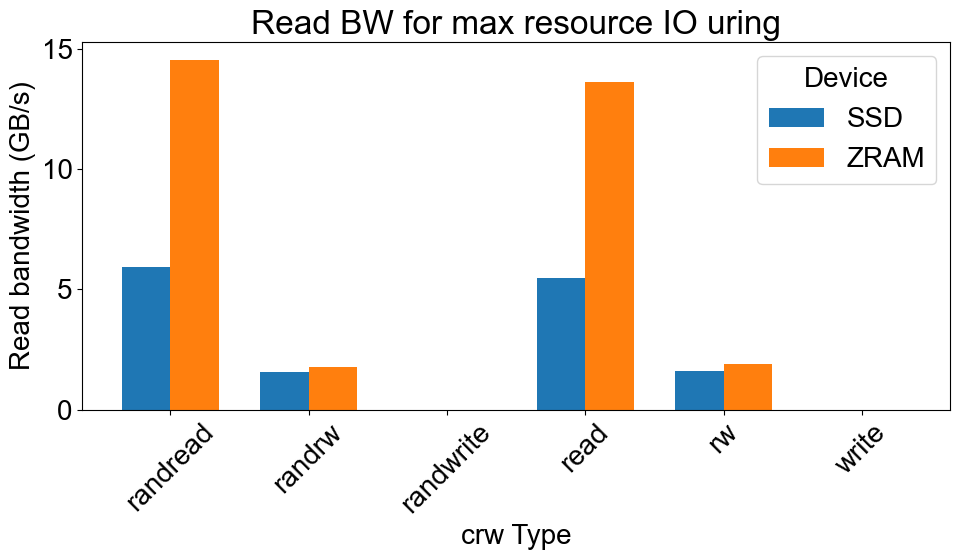

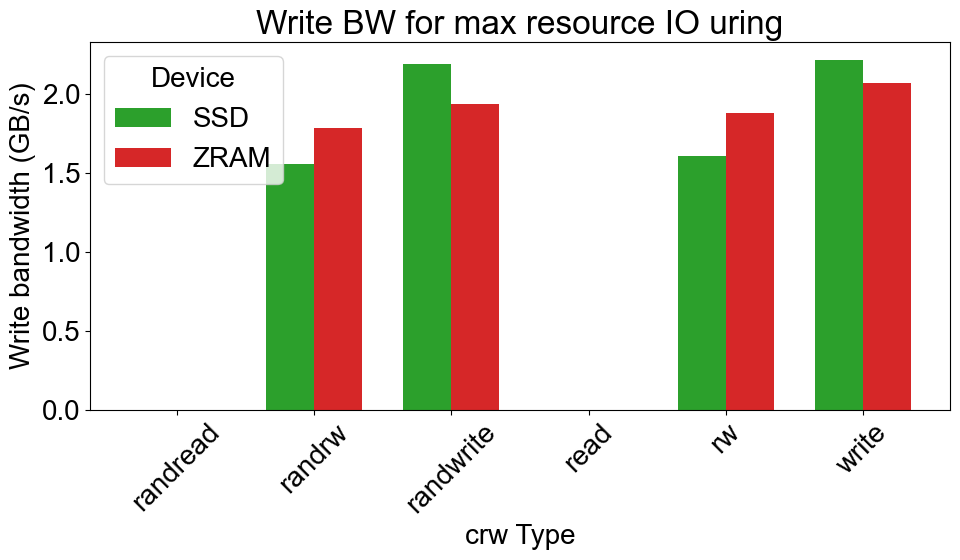

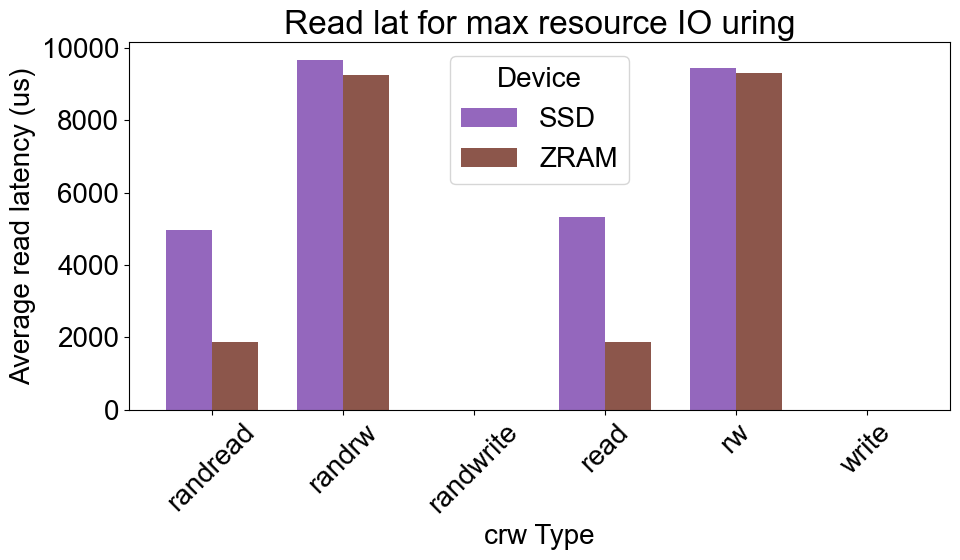

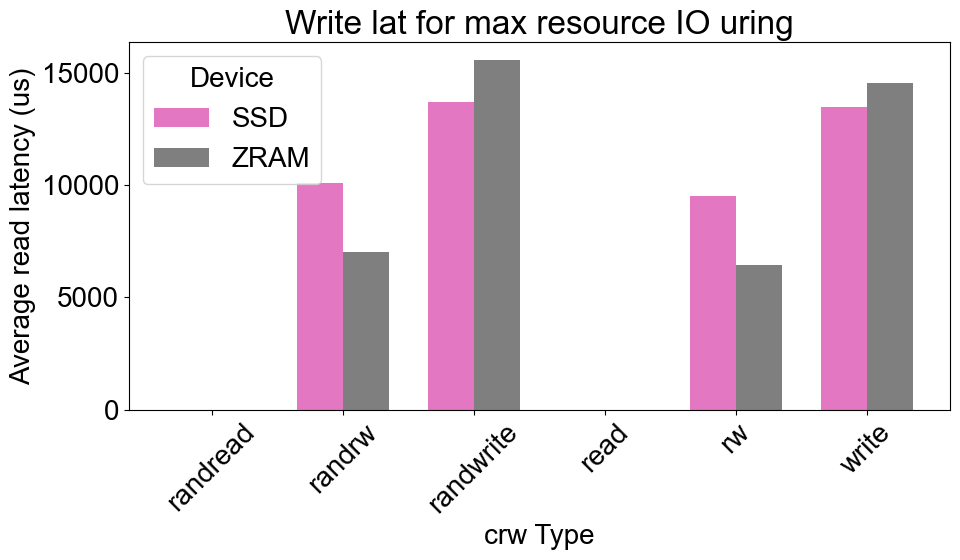

In [15]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='io_uring' AND ciodepth='128' AND cnproc='64'
"""
df = pdsqleval(query.format(params))
df["readBW_GB"] = df["readBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["writeBW_GB"] = df["writeBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["avgreadlat_us"] = df["avgreadlat_ns"]/1000.0
df["avgwritelat_us"] = df["avgwritelat_ns"]/1000.0

graph_output(df, "readBW_GB", "Read bandwidth (GB/s)", "Read BW for max resource IO uring", f"{outDir}/graphs/readBW/max-iouring.png")
graph_output(df, "writeBW_GB", "Write bandwidth (GB/s)", "Write BW for max resource IO uring", f"{outDir}/graphs/writeBW/max-iouring.png", bar_colors=['#2ca02c', '#d62728'])
graph_output(df, "avgreadlat_us", "Average read latency (us)", "Read lat for max resource IO uring", f"{outDir}/graphs/readlat/max-iouring.png", bar_colors=['#9467bd', '#8c564b'])
graph_output(df, "avgwritelat_us", "Average read latency (us)", "Write lat for max resource IO uring", f"{outDir}/graphs/writelat/max-iouring.png", bar_colors=['#e377c2', '#7f7f7f'])

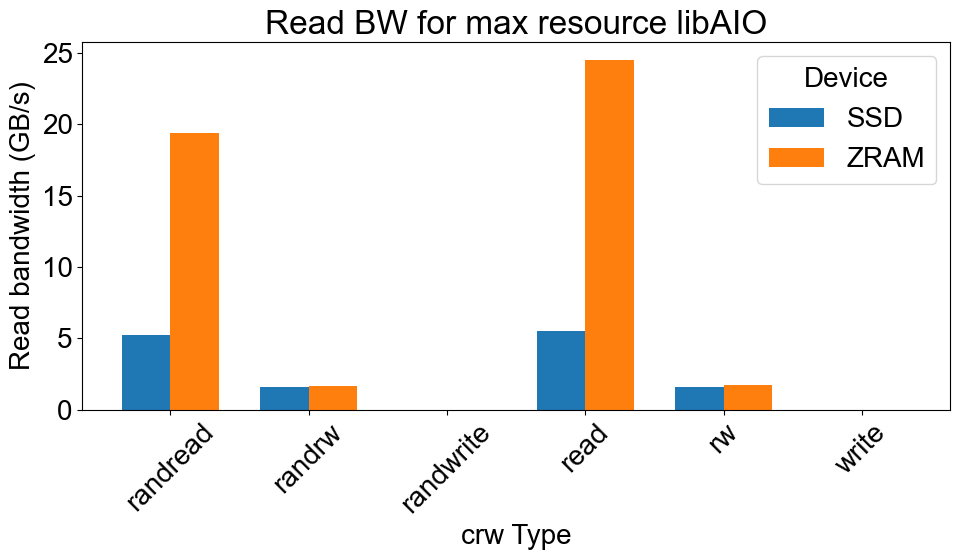

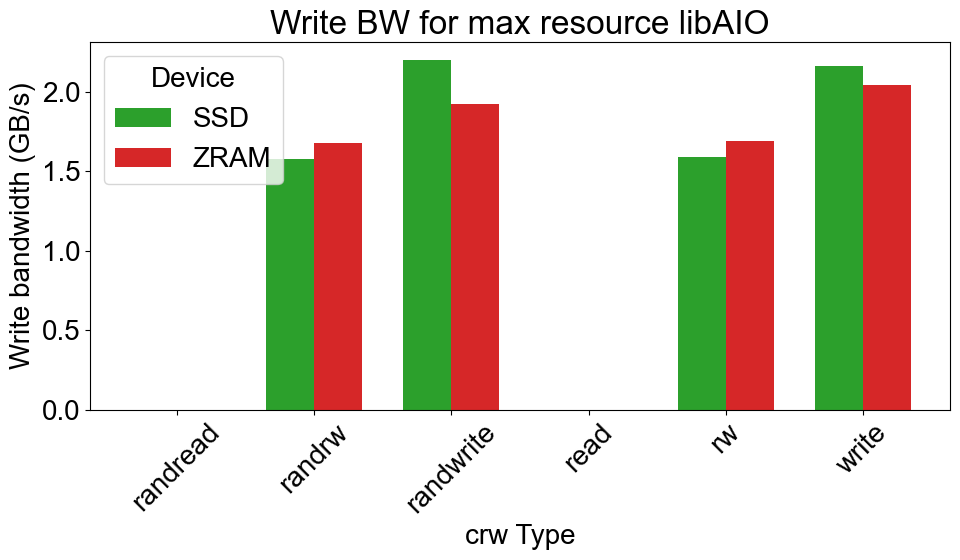

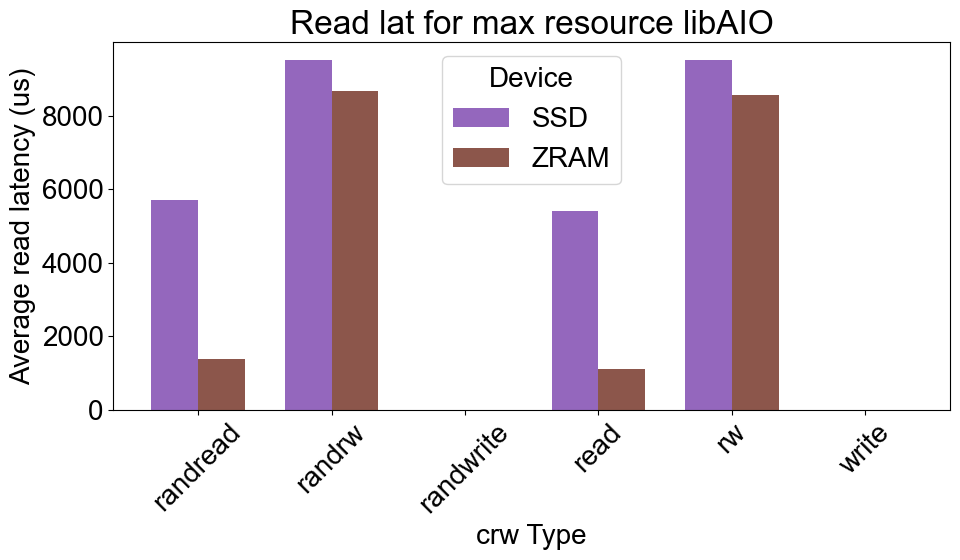

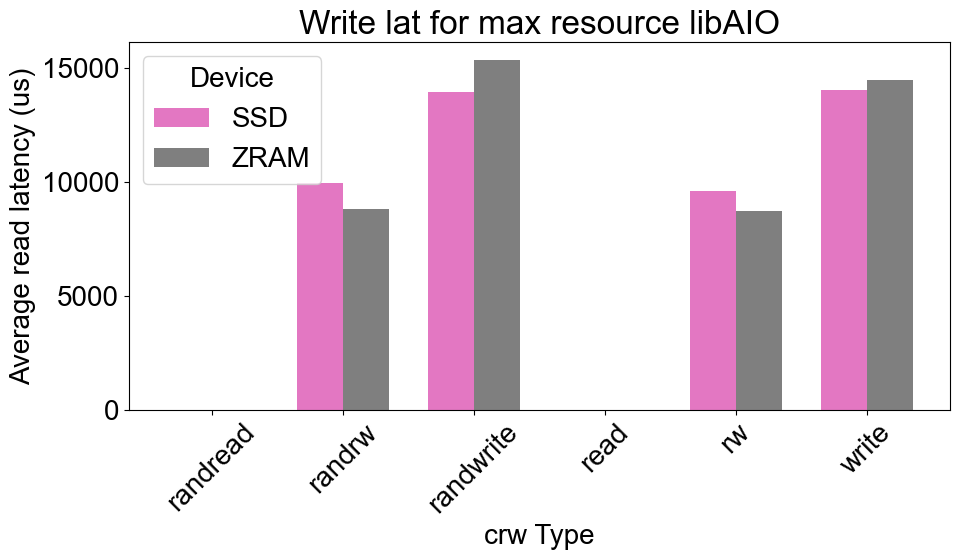

In [16]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='libaio' AND ciodepth='128' AND cnproc='64'
"""
df = pdsqleval(query.format(params))
df["readBW_GB"] = df["readBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["writeBW_GB"] = df["writeBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["avgreadlat_us"] = df["avgreadlat_ns"]/1000.0
df["avgwritelat_us"] = df["avgwritelat_ns"]/1000.0

graph_output(df, "readBW_GB", "Read bandwidth (GB/s)", "Read BW for max resource libAIO", f"{outDir}/graphs/readBW/max-libaio.png")
graph_output(df, "writeBW_GB", "Write bandwidth (GB/s)", "Write BW for max resource libAIO", f"{outDir}/graphs/writeBW/max-libaio.png", bar_colors=['#2ca02c', '#d62728'])
graph_output(df, "avgreadlat_us", "Average read latency (us)", "Read lat for max resource libAIO", f"{outDir}/graphs/readlat/max-libaio.png", bar_colors=['#9467bd', '#8c564b'])
graph_output(df, "avgwritelat_us", "Average read latency (us)", "Write lat for max resource libAIO", f"{outDir}/graphs/writelat/max-libaio.png", bar_colors=['#e377c2', '#7f7f7f'])

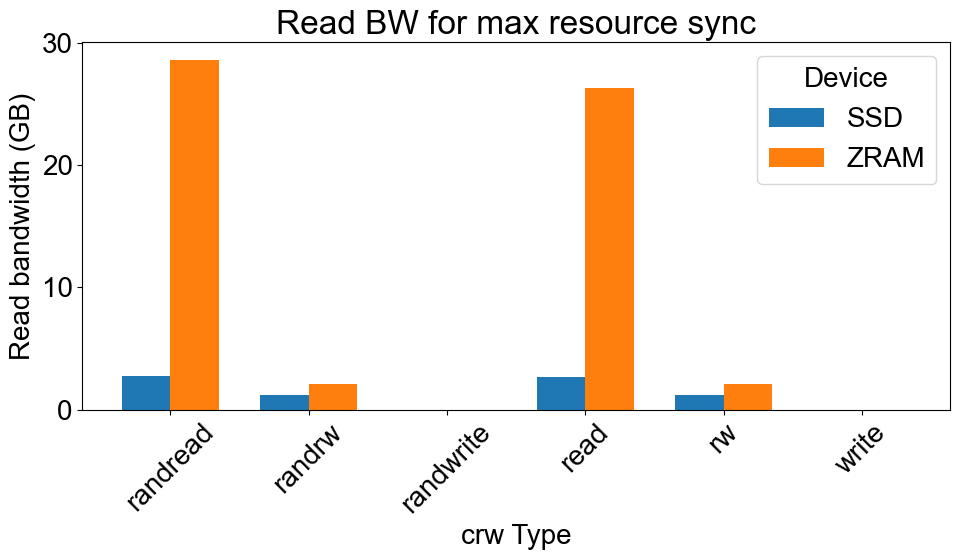

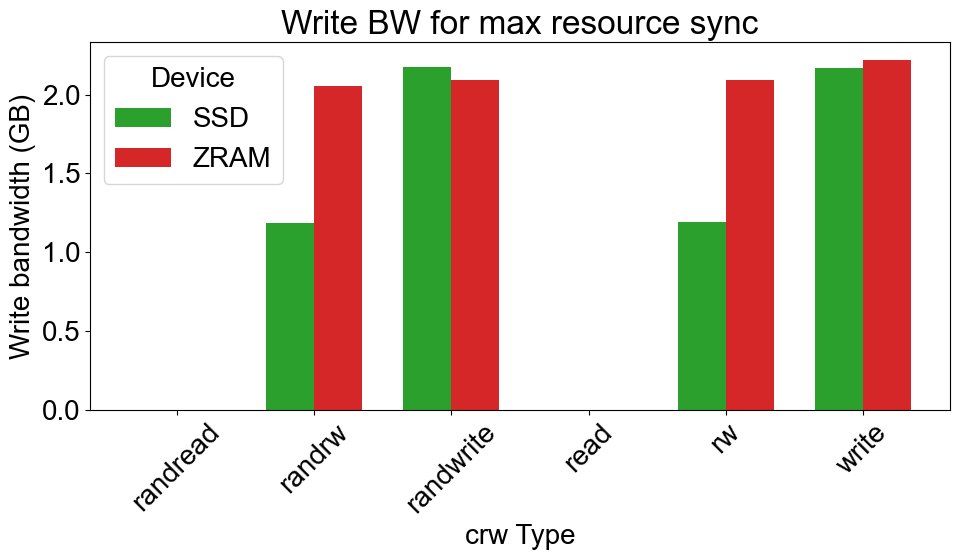

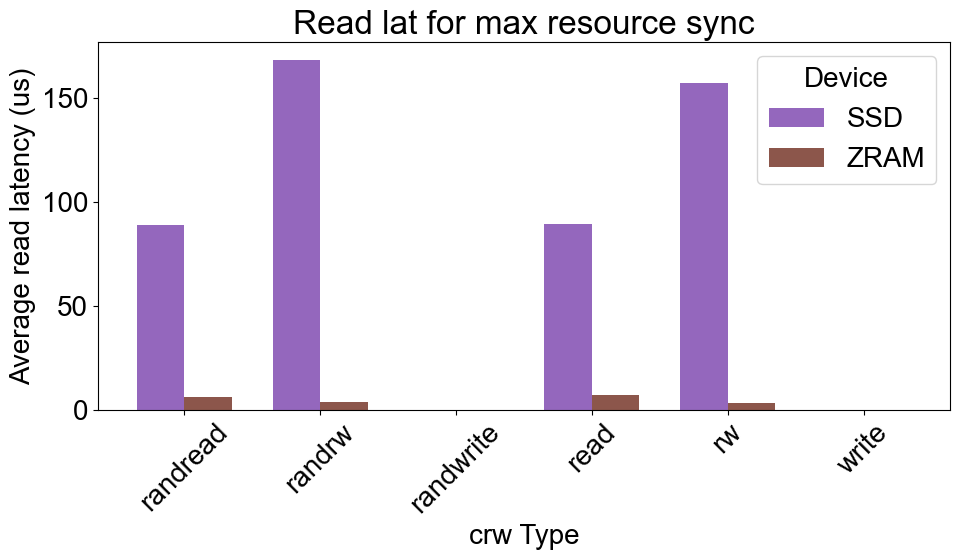

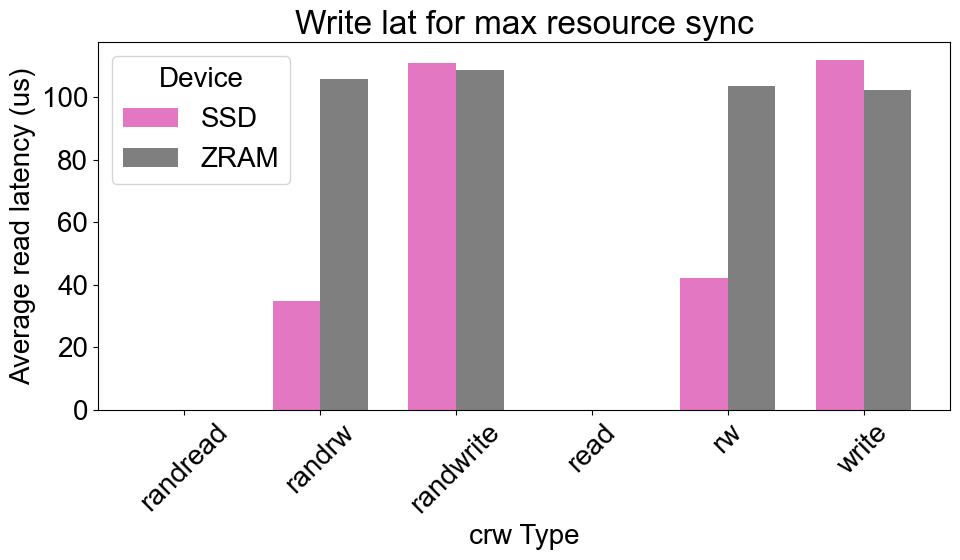

In [17]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='sync' AND cnproc='64'
"""
df = pdsqleval(query.format(params))
df["readBW_GB"] = df["readBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["writeBW_GB"] = df["writeBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["avgreadlat_us"] = df["avgreadlat_ns"]/1000.0
df["avgwritelat_us"] = df["avgwritelat_ns"]/1000.0

graph_output(df, "readBW_GB", "Read bandwidth (GB)", "Read BW for max resource sync", f"{outDir}/graphs/readBW/max-sync.png")
graph_output(df, "writeBW_GB", "Write bandwidth (GB)", "Write BW for max resource sync", f"{outDir}/graphs/writeBW/max-sync.png", bar_colors=['#2ca02c', '#d62728'])
graph_output(df, "avgreadlat_us", "Average read latency (us)", "Read lat for max resource sync", f"{outDir}/graphs/readlat/max-sync.png", bar_colors=['#9467bd', '#8c564b'])
graph_output(df, "avgwritelat_us", "Average read latency (us)", "Write lat for max resource sync", f"{outDir}/graphs/writelat/max-sync.png", bar_colors=['#e377c2', '#7f7f7f'])

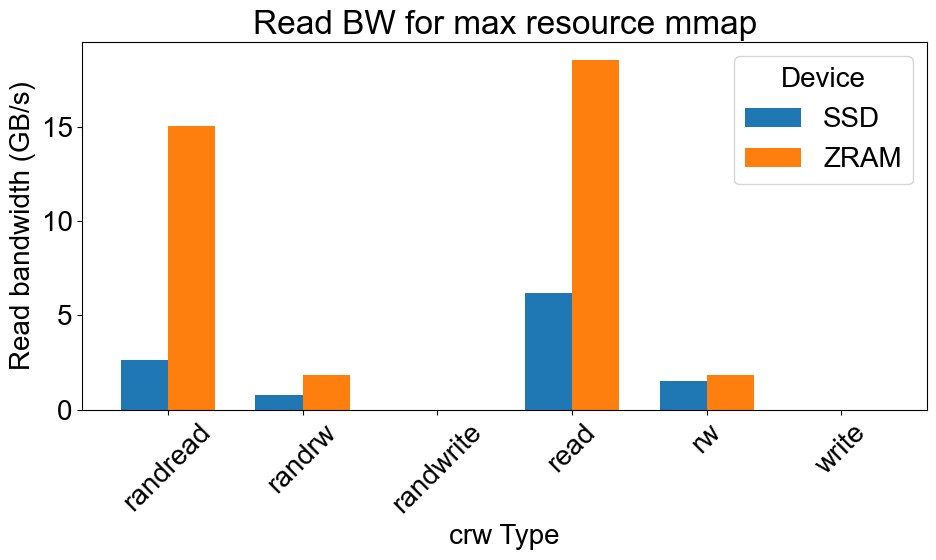

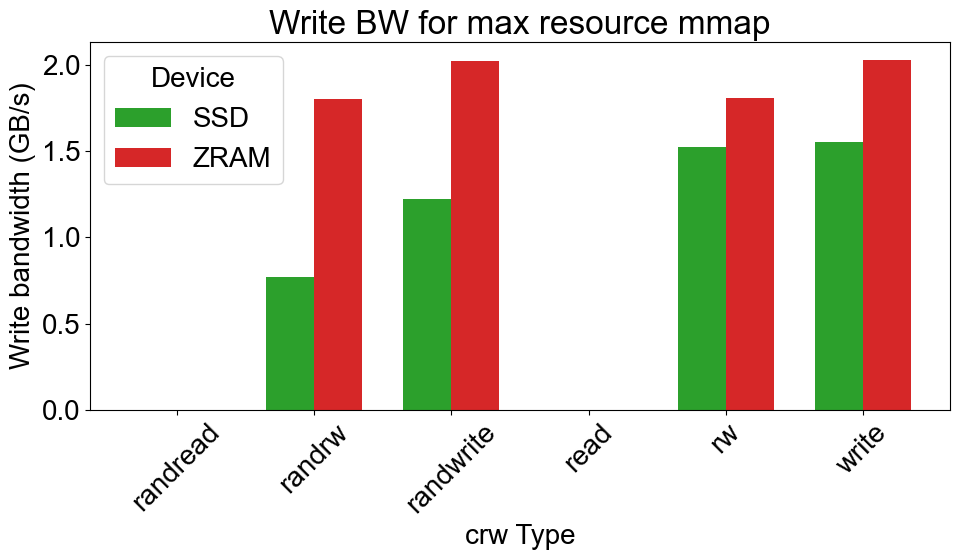

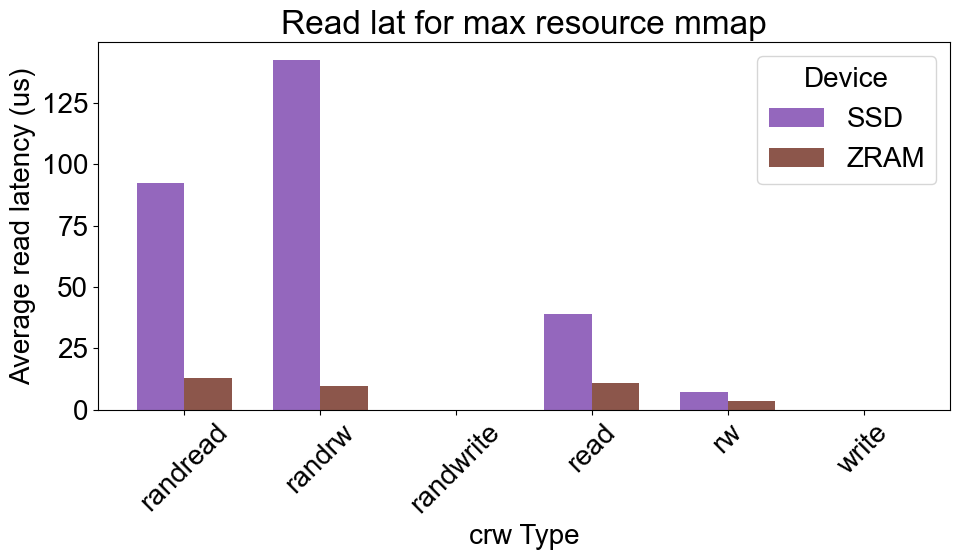

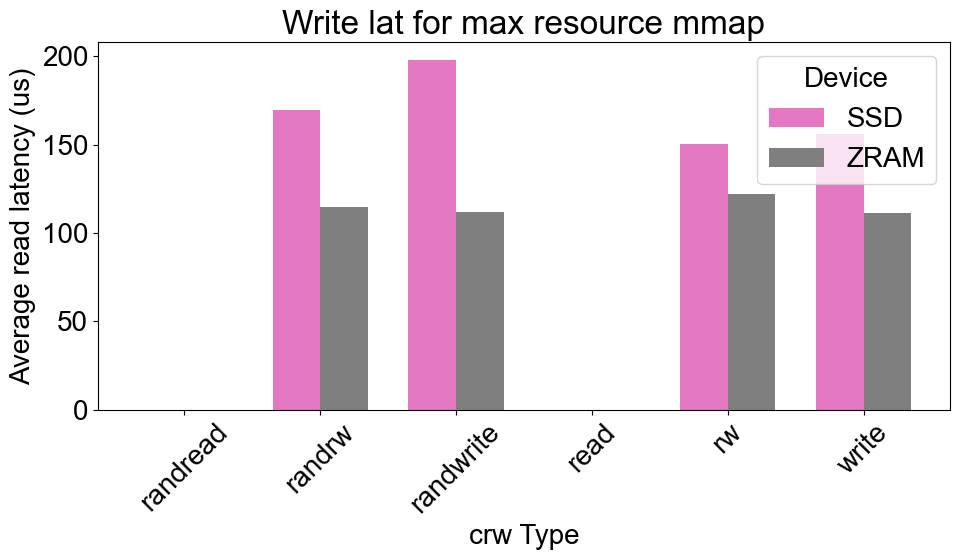

In [18]:
query = """
     SELECT {}
     FROM master2
     WHERE cioengine='mmap' AND cnproc='64'
"""
df = pdsqleval(query.format(params))
df["readBW_GB"] = df["readBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["writeBW_GB"] = df["writeBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
df["avgreadlat_us"] = df["avgreadlat_ns"]/1000.0
df["avgwritelat_us"] = df["avgwritelat_ns"]/1000.0

graph_output(df, "readBW_GB", "Read bandwidth (GB/s)", "Read BW for max resource mmap", f"{outDir}/graphs/readBW/max-mmap.png")
graph_output(df, "writeBW_GB", "Write bandwidth (GB/s)", "Write BW for max resource mmap", f"{outDir}/graphs/writeBW/max-mmap.png", bar_colors=['#2ca02c', '#d62728'])
graph_output(df, "avgreadlat_us", "Average read latency (us)", "Read lat for max resource mmap", f"{outDir}/graphs/readlat/max-mmap.png", bar_colors=['#9467bd', '#8c564b'])
graph_output(df, "avgwritelat_us", "Average read latency (us)", "Write lat for max resource mmap", f"{outDir}/graphs/writelat/max-mmap.png", bar_colors=['#e377c2', '#7f7f7f'])